2025-06-05 17:38:37,267 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+01/s


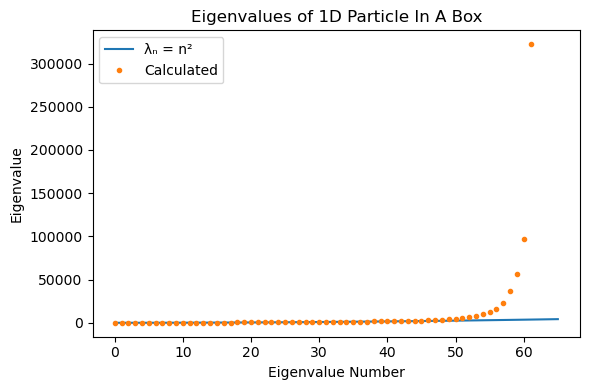

In [11]:
import dedalus.public as d3
import numpy as np
import matplotlib.pyplot as plt
import logging
import scipy.constants as sc

'''
Code solving a simplified 1D particle in a box equation:
    -d²ψ/dx² = λψ
With x ∈ [0, π] as boundaries with ψ(0) = ψ(π) = 0. Checking to see if the solution roughly fits the
predicted solution of λₙ = n²
'''
#Setting vars
pi = np.pi

#Basis
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=np.float64)
xbasis = d3.Chebyshev(xcoord, 64, bounds=(0, np.pi), dealias=3/2)

#Fields
psi = dist.Field(name='psi', bases=xbasis)
lam = dist.Field(name='lam')
tau1 = dist.Field(name='tau1')
tau2 = dist.Field(name='tau2')

#Subs
x = dist.local_grid(xbasis)
dx = lambda A: d3.Differentiate(A, xcoord)
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
psix = dx(psi) + lift(tau1)
psixx = dx(psix) + lift(tau2)

#Problem
problem = d3.EVP([psi, tau1, tau2], eigenvalue=lam, namespace=locals())
problem.add_equation("- psixx - lam*psi = 0")
problem.add_equation("psi(x = 0) = 0")
problem.add_equation("psi(x = pi) = 0")

#Solver
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)
n = np.arange(evals.size)
true_evals = n**2

#Plotting solutions
plt.figure(figsize=(6,4))
plt.plot(n, true_evals)
plt.plot(n, evals, '.')
plt.xlabel("Eigenvalue Number")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of 1D Particle In A Box")
plt.tight_layout()
plt.legend(['λₙ = n²', 'Calculated'])
plt.savefig("1d_particle_box.png", dpi=200)